#Capitulo 4 Modelado

importaciones y definición de la capeta de trabajo

In [ ]:
import os
import json
import pandas as pd
import shap

from google.colab import drive
drive.mount('/content/drive')

#carpeta de trabajo principal
folder_path = "/content/drive/MyDrive/Analisis_Multimodal_Comunicacion_TFM/data/folder_path"
#carpeta para guardar los modelos
model_path = "/content/drive/MyDrive/Analisis_Multimodal_Comunicacion_TFM/models"

os.makedirs(folder_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
#lectura del archivo con los datos definitivos y agragados
df_model=pd.read_csv(os.path.join(folder_path, "df_model.csv"))
#hacemos una copia
df_model1=df_model.copy()
print(df_model1.info())
print(df_model1.isnull().any().any())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Columns: 118 entries, duracion_video to expresividad
dtypes: bool(16), float64(91), int64(10), object(1)
memory usage: 1.5+ MB
None
False


## 4.1 Entrenamiento del modelo predictivo

Para el entrenamiento del modelo se utilizó el conjunto de datos unificado a nivel de vídeo (df_model.csv), que contiene variables textuales, acústicas, visuales y emocionales previamente descritas. El objetivo del modelo es predecir la calidad comunicativa de un discurso, representada por la variable tipo_comunicador, y generar una probabilidad continua asociada a la clase 1, que será utilizada posteriormente como estimación del nivel de calidad comunicativa.

Selección del modelo

Se optó por un modelo de Random Forest debido a tres ventajas clave:

Robustez ante ruido y variables correlacionadas, lo cual es útil en entornos multimodales como este, donde coexisten métricas del habla, del texto y del gesto.

Capacidad para manejar variables de distinta naturaleza (continuas, categóricas, transformadas).

Alto grado de explicabilidad, fundamental en este trabajo, ya que uno de los objetivos es ofrecer feedback comprensible al usuario final sobre qué factores influyen en la calidad de su comunicación.

La probabilidad de pertenencia a la clase 1 generada por el modelo (probabilidad_tipo_1) se utilizará como medida continua de calidad del discurso, lo que permite no solo clasificar a los oradores, sino también ordenarlos y compararlos de forma graduada.

Evaluación del modelo

El modelo fue entrenado utilizando validación estratificada, y evaluado mediante métricas estándar de clasificación binaria:

Accuracy: proporción de aciertos sobre el total de casos.

F1-score: medida balanceada entre precisión y exhaustividad.

Matriz de confusión: análisis de errores por clase.

Curva ROC y AUC: para evaluar la capacidad discriminativa del modelo a distintos umbrales de decisión.

La combinación de estas métricas permite valorar no solo el rendimiento global del modelo, sino también su equilibrio en la clasificación de ambas clases (comunicadores de baja y alta calidad).

Los resultados obtenidos se describen en detalle en el apartado siguiente.

              precision    recall  f1-score   support

           0       0.70      0.69      0.70       191
           1       0.68      0.69      0.68       180

    accuracy                           0.69       371
   macro avg       0.69      0.69      0.69       371
weighted avg       0.69      0.69      0.69       371

Matriz de Confusión
[[132  59]
 [ 56 124]]
Accuracy: 0.6900269541778976


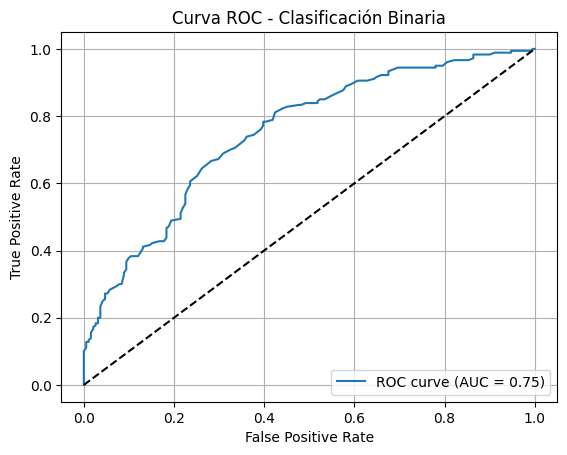

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import joblib
import pandas as pd

# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(['video_id','tipo_comunicador'], axis=1),
                                                    df_model1['tipo_comunicador'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df_model1['tipo_comunicador'])

# -----------------------------
# Entrenar modelo
# -----------------------------
model1 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model1.fit(X_train, y_train)

# -----------------------------
# Predicciones
# -----------------------------
y_pred = model1.predict(X_test)

# -----------------------------
# Evaluación
# -----------------------------
print(classification_report(y_test, y_pred))
print('Matriz de Confusión')
print(confusion_matrix(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

# -----------------------------
# Curva ROC
# -----------------------------

y_proba = model1.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
auc = roc_auc_score(y_test, y_proba[:,1])

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación Binaria')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Evaluación del modelo:

El modelo Random Forest alcanzó una precisión (accuracy) del 69% en la clasificación binaria de tipo de comunicador, con un AUC de 0.75 en la curva ROC, lo que indica una capacidad de discriminación aceptable. Las métricas de precision, recall y F1-score fueron equilibradas entre ambas clases (aproximadamente 0.68–0.70), sin evidencias de desbalance. Estos resultados muestran que el modelo logra distinguir razonablemente entre los tipos de comunicador, aunque existe margen de mejora mediante técnicas de optimización o enriquecimiento de características.

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
def plot_feature_importance(model, X_train):
    feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

    fig = px.bar(feat_importances, x=feat_importances.index, y='Importance', title='Feature Importances', labels={'x': 'Features', 'Importance': 'Importance'}, template='plotly_white')
    fig.show()

    return feat_importances

In [ ]:
feature_importances=plot_feature_importance(model1, X_train)
lista = feature_importances
print(lista.head(50))
lista_final=lista.index

                              Importance
pmm_var                         0.026165
duracion_video                  0.025720
claridad_oraciones              0.023018
rms_brazos                      0.022224
rms_mean_mean                   0.020587
zcr_mean_min                    0.018634
rms_zcr_var_ratio               0.017615
rms_mean_var                    0.017112
pausa_anterior_mean             0.016947
pmm_mean                        0.016031
anecdotas                       0.015670
pmm_min                         0.015444
impacto_anecdotas_detectadas    0.015351
rms_mean_min                    0.014947
emocion_audio_fearful_mean      0.014908
yaw_max                         0.014597
ceño_fruncido_max               0.014316
ejemplos                        0.014096
zcr_ceño                        0.013968
rms_mean_max                    0.013597
apertura_brazos_max             0.012126
zcr_mean_mean                   0.011951
pitch_max                       0.011896
pitch_min       

Un plot del rendimiento con respecto al número de variables

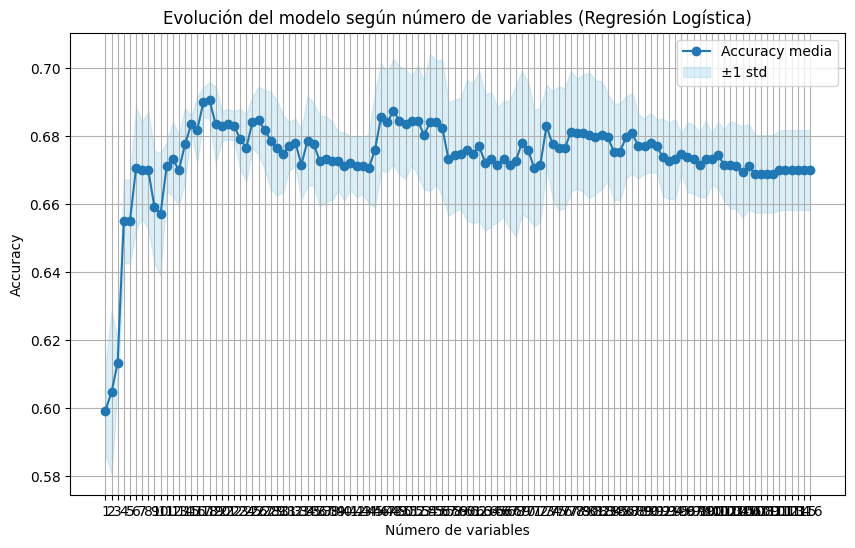

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# -----------------------------
# Datos
# -----------------------------
X = df_model1[lista_final]  # features seleccionadas
y = df_model1['tipo_comunicador']

# -----------------------------
# Evaluar rendimiento según número de variables
# -----------------------------
scores_mean = []
scores_std = []
n_features_list = range(1, len(lista_final)+1)

for n in n_features_list:
    X_sub = X[lista_final[:n]]  # usar las primeras n features

    # Pipeline con estandarización + regresión logística
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000, solver='lbfgs')
    )

    # Validación cruzada 5-fold
    scores = cross_val_score(model, X_sub, y, cv=5, scoring='accuracy')
    scores_mean.append(scores.mean())
    scores_std.append(scores.std())

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(n_features_list, scores_mean, marker='o', label='Accuracy media')
plt.fill_between(
    n_features_list,
    np.array(scores_mean)-np.array(scores_std),
    np.array(scores_mean)+np.array(scores_std),
    color='skyblue', alpha=0.3, label='±1 std'
)
plt.xticks(n_features_list)
plt.xlabel("Número de variables")
plt.ylabel("Accuracy")
plt.title("Evolución del modelo según número de variables (Regresión Logística)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
lista_final[:30]

Index(['pmm_var', 'duracion_video', 'claridad_oraciones', 'rms_brazos',
       'rms_mean_mean', 'zcr_mean_min', 'rms_zcr_var_ratio', 'rms_mean_var',
       'pausa_anterior_mean', 'pmm_mean', 'anecdotas', 'pmm_min',
       'impacto_anecdotas_detectadas', 'rms_mean_min',
       'emocion_audio_fearful_mean', 'yaw_max', 'ceño_fruncido_max',
       'ejemplos', 'zcr_ceño', 'rms_mean_max', 'apertura_brazos_max',
       'zcr_mean_mean', 'pitch_max', 'pitch_min', 'emocion_audio_calm_mean',
       'yaw_min', 'ojos_abiertos_max', 'apertura_brazos_min',
       'apertura_brazos_var', 'inclinacion_torso_min'],
      dtype='object')

Hago una seleccion de variables centrandome en su importancia para el modelo y a su vez permitan una buena explicabilidad.

In [ ]:
selected_features = [
    'claridad_oraciones',             # Claridad sintáctica y gramatical del texto
    'impacto_palabras_poder',         # Uso de palabras con carga persuasiva
    'impacto_anecdotas_detectadas',   # Impacto ponderado de las anécdotas
    'anecdotas',                      # Presencia de anécdotas
    'ejemplos',                       # Uso de ejemplos concretos
    'rms_mean_mean',                 # Energía media de la voz
    'rms_mean_var',                  # Variabilidad de la energía vocal
    'rms_zcr_var_ratio',             # Relación energía-ritmo
    'rms_brazos',                    # Coordinación audio-gesto
    'pmm_mean',                      # Velocidad de habla (palabras por minuto)
    'zcr_mean_min',                  # Pausas prolongadas
    'yaw_max',                       # Movimiento de cabeza
    'pitch_min',                     # Tono bajo (entonación emocional)
    'apertura_brazos_var',           # Variabilidad de apertura de brazos
    'expresividad_facial',           # Nivel de expresividad facial
    'expresividad_gestual',          # Nivel de expresividad gestual
    'duracion_video',                # Duración total del video
    'emocion_audio_happy_mean',      # Promedio de emoción "feliz"
    'emocion_audio_fearful_mean',    # Promedio de emoción "miedo"
    'emocion_audio_angry_mean',      # Promedio de emoción "enojo"
    'emocion_audio_surprised_mean',  # Promedio de emoción "sorpresa"
    'emocion_audio_disgust_mean',    # Promedio de emoción "asco"
    'emocion_audio_calm_mean'        # Promedio de emoción "calma"

]

In [ ]:
# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(df_model1[selected_features],
                                                    df_model1['tipo_comunicador'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df_model1['tipo_comunicador'])

# -----------------------------
# Entrenar modelo
# -----------------------------
model3 = RandomForestClassifier(n_estimators=200,random_state=42, class_weight='balanced').fit(X_train,y_train)

y_pred= model3.predict(X_test)
# -----------------------------
# Evaluar modelo
# -----------------------------
print(classification_report(y_test, y_pred))
print('Matriz de Confusión')
print(confusion_matrix(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       191
           1       0.70      0.71      0.70       180

    accuracy                           0.71       371
   macro avg       0.71      0.71      0.71       371
weighted avg       0.71      0.71      0.71       371

Matriz de Confusión
[[135  56]
 [ 52 128]]
Accuracy: 0.7088948787061995


Reviso si mejora con diferentes transformaciones

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 20 are removed. Consider decreasing the number of bins.

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 21 are removed. Consider decreasing the number of bins.



Mejor preprocesamiento: {'preprocess': KBinsDiscretizer(encode='ordinal', n_bins=10)}

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69       191
           1       0.67      0.67      0.67       180

    accuracy                           0.68       371
   macro avg       0.68      0.68      0.68       371
weighted avg       0.68      0.68      0.68       371

Matriz de confusión:
 [[132  59]
 [ 60 120]]
Accuracy: 0.6792452830188679

Resumen comparativo de transformaciones:
                                 param_preprocess  mean_test_score  \
3  KBinsDiscretizer(encode='ordinal', n_bins=10)         0.708313   
0                                    passthrough         0.697500   
1                               StandardScaler()         0.697500   
2                                 MinMaxScaler()         0.694799   
4                           SafeLogTransformer()         0.677223   

   std_test_score  
3        0

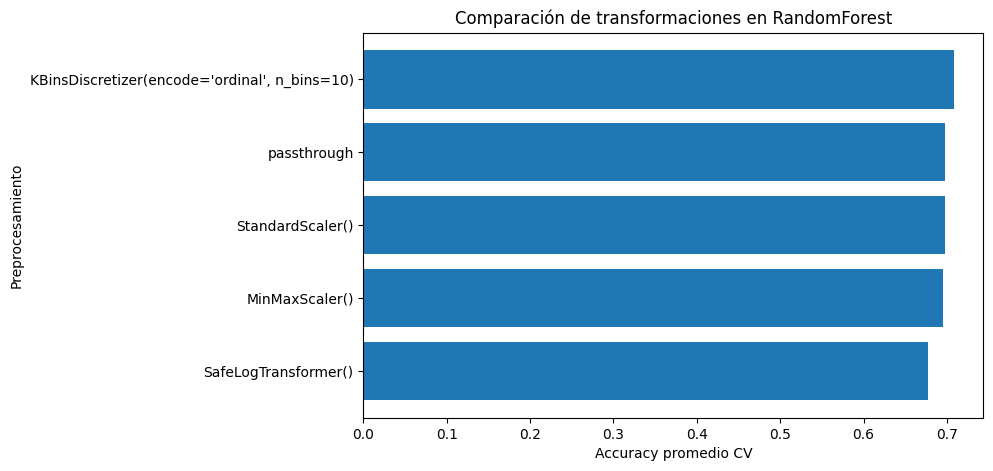

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

# -----------------------------
# Transformador log seguro
# -----------------------------
class SafeLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Shift para evitar negativos o ceros
        X_shifted = X - X.min(axis=0) + 1e-6
        return np.log(X_shifted)

# -----------------------------
# División de datos
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df_model1[selected_features],
    df_model1['tipo_comunicador'],
    test_size=0.2,
    random_state=42,
    stratify=df_model1['tipo_comunicador']
)

# -----------------------------
# Pipeline con RandomForest
# -----------------------------
pipeline = Pipeline([
    ('preprocess', 'passthrough'),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

# -----------------------------
# Transformaciones a probar
# -----------------------------
param_grid = {
    'preprocess': [
        'passthrough',  # sin transformar
        StandardScaler(),  # estandarización
        MinMaxScaler(),    # normalización
        KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'),  # binning
        SafeLogTransformer()  # log seguro
    ]
}

# -----------------------------
# GridSearch para comparar
# -----------------------------
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train, y_train)

# -----------------------------
# Resultados del mejor modelo
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejor preprocesamiento:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# -----------------------------
# Comparación de todas las transformaciones
# -----------------------------
results = pd.DataFrame(grid.cv_results_)
results_summary = results[['param_preprocess', 'mean_test_score', 'std_test_score']]
results_summary = results_summary.sort_values(by='mean_test_score', ascending=False)
print("\nResumen comparativo de transformaciones:\n", results_summary)

# -----------------------------
# Gráfico de comparación
# -----------------------------
plt.figure(figsize=(8,5))
plt.barh(results_summary['param_preprocess'].astype(str), results_summary['mean_test_score'])
plt.xlabel('Accuracy promedio CV')
plt.ylabel('Preprocesamiento')
plt.title('Comparación de transformaciones en RandomForest')
plt.gca().invert_yaxis()
plt.show()



REviso si mejora con diferentes hiperparametros

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_param = {
    'n_estimators': [100, 200, 300, 400],  # más árboles
    'max_depth': [20, 24, 28, 32],         # profundidades mayores
    'min_samples_split': [2, 5, 10],       # opcional, para evitar overfitting
    'min_samples_leaf': [1, 2, 4]          # opcional, suaviza el modelo
}

model_grid = GridSearchCV(
    estimator=model3,
    param_grid=grid_param,
    scoring='recall',  # o 'f1' si quieres balancear precisión/recall
    cv=5,
    n_jobs=-1
)

model_grid.fit(X_train, y_train)

print("Mejores parámetros:", model_grid.best_params_)
print("Mejor score (recall):", model_grid.best_score_)

Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mejor score (recall): 0.7125874125874125


              precision    recall  f1-score   support

           0       0.74      0.70      0.72       191
           1       0.70      0.73      0.72       180

    accuracy                           0.72       371
   macro avg       0.72      0.72      0.72       371
weighted avg       0.72      0.72      0.72       371

Matriz de Confusión
[[134  57]
 [ 48 132]]
Accuracy: 0.7169811320754716


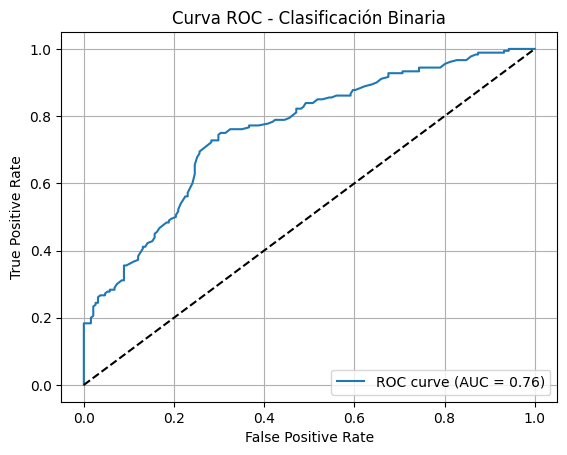

In [ ]:
# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(df_model1[selected_features],
                                                    df_model1['tipo_comunicador'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df_model1['tipo_comunicador'])

# -----------------------------
# Entrenar modelo
# -----------------------------

model4 = RandomForestClassifier(n_estimators=300,random_state=42, class_weight='balanced').fit(X_train,y_train)

y_pred= model4.predict(X_test)
# -----------------------------
# Evaluar modelo
# -----------------------------

print(classification_report(y_test, y_pred))
print('Matriz de Confusión')
print(confusion_matrix(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

# -----------------------------
# Curva ROC
# -----------------------------

y_proba = model4.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
auc = roc_auc_score(y_test, y_proba[:,1])

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación Binaria')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

El modelo alcanzó un rendimiento global del 72% de acierto, con una capacidad de discriminación moderadamente alta (AUC = 0.76). Las métricas están equilibradas entre ambas clases, lo que indica que el sistema no favorece un tipo de comunicador sobre otro. Estas mejoras se lograron tras ajustar cuidadosamente la selección de variables explicativas y combinar información textual, vocal y gestual.

Decidimos tambien investigar que pasaría si entrenasemos el modelo con datos mejores, es decir con menos porcentaje de nulos, filtramos por cara_detectada mayor del 40%

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       160
           1       0.70      0.67      0.68       150

    accuracy                           0.70       310
   macro avg       0.70      0.70      0.70       310
weighted avg       0.70      0.70      0.70       310

Matriz de Confusión
[[118  42]
 [ 50 100]]
Accuracy: 0.7032258064516129


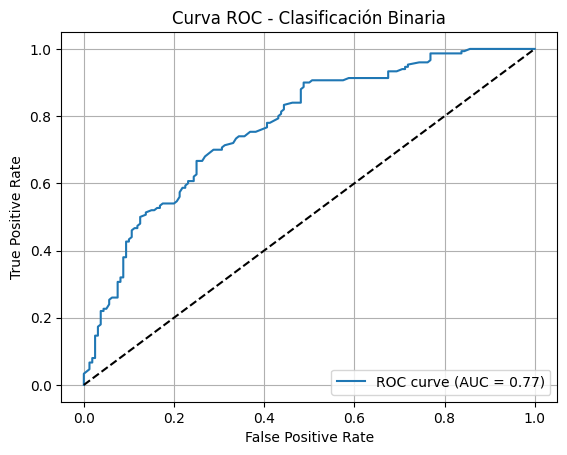

In [ ]:
df_model_calidad4 = df_model1[df_model1['porcentaje_cara_detectada_max'] >= 4].reset_index(drop=True)
for col in selected_features:
    if col not in df_model_calidad4:
        df_model_calidad4[col] = 0  # o np.nan según convenga

# Seleccionar columnas en el mismo orden que en entrenamiento
X_model = df_model_calidad4[selected_features].copy()
Y_model = df_model_calidad4['tipo_comunicador']

# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_model,
                                                    Y_model,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = Y_model)

# -----------------------------
# Entrenar modelo
# -----------------------------
model5 = RandomForestClassifier(n_estimators=300,random_state=42, class_weight='balanced').fit(X_train,y_train)

y_pred= model5.predict(X_test)
# -----------------------------
# Evaluar modelo
# -----------------------------
print(classification_report(y_test, y_pred))
print('Matriz de Confusión')
print(confusion_matrix(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
# -----------------------------
# Curva ROC
# -----------------------------

y_proba = model5.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
auc = roc_auc_score(y_test, y_proba[:,1])

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación Binaria')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



Aparentemente tenemos resultados parecidos, pero vamos a comprobar como seria el modelo4 con esos datos

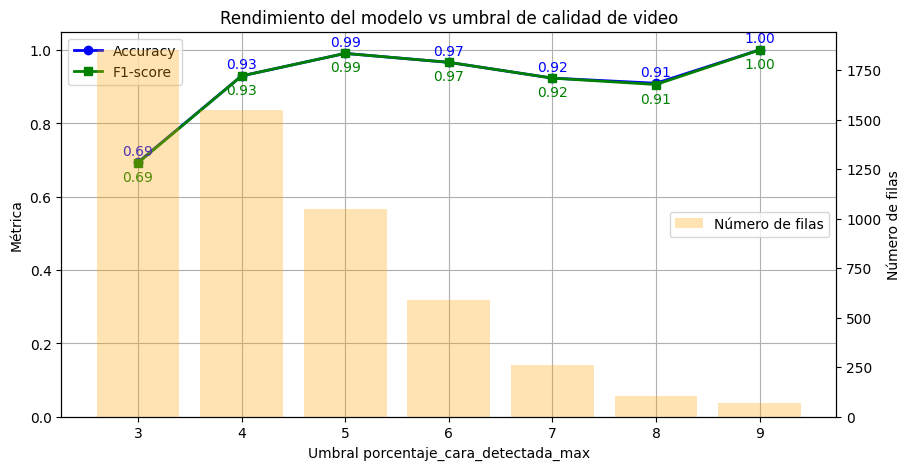

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

def plot_rendimiento_vs_calidad_video(model, data,selected_features):
        # Umbrales de calidad de video
    thresholds = range(3, 10)
    accuracies = []
    f1_scores = []
    num_rows = []

    for t in thresholds:
        df_filtered = data[data['porcentaje_cara_detectada_max'] >= t].reset_index(drop=True)
        for col in selected_features:
            if col not in df_filtered.columns:
                df_filtered[col] = 0  # o np.nan según convenga

        # Seleccionar columnas en el mismo orden que en entrenamiento
        X_model = df_filtered[selected_features].copy()
        Y_model = df_filtered['tipo_comunicador']
        n = df_filtered.shape[0]
        num_rows.append(n)

        if n == 0:
            accuracies.append(None)
            f1_scores.append(None)
            continue

        X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
            X_model,
            Y_model,
            test_size=0.1,
            random_state=42,
            stratify=Y_model
        )

        y_pred_tmp = model.predict(X_test_tmp)

        accuracies.append(accuracy_score(y_test_tmp, y_pred_tmp))
        f1_scores.append(f1_score(y_test_tmp, y_pred_tmp, average='weighted'))

    # -----------------------------
    # Gráfico combinado
    # -----------------------------
    fig, ax1 = plt.subplots(figsize=(10,5))

    # Líneas de Accuracy y F1-score
    ax1.plot(thresholds, accuracies, marker='o', label='Accuracy', color='blue', linewidth=2)
    ax1.plot(thresholds, f1_scores, marker='s', label='F1-score', color='green', linewidth=2)
    ax1.set_xlabel('Umbral porcentaje_cara_detectada_max')
    ax1.set_ylabel('Métrica')
    ax1.set_ylim(0,1.05)
    ax1.grid(True)
    ax1.legend(loc='upper left')

    # Mostrar valores encima de los puntos
    for x, y in zip(thresholds, accuracies):
        if y is not None:
            ax1.text(x, y+0.02, f"{y:.2f}", ha='center', color='blue')
    for x, y in zip(thresholds, f1_scores):
        if y is not None:
            ax1.text(x, y-0.05, f"{y:.2f}", ha='center', color='green')

    # Barras del número de filas
    ax2 = ax1.twinx()
    ax2.bar(thresholds, num_rows, alpha=0.3, color='orange', label='Número de filas')
    ax2.set_ylabel('Número de filas')
    ax2.legend(loc='center right')

    plt.title('Rendimiento del modelo vs umbral de calidad de video')
    plt.show()

plot_rendimiento_vs_calidad_video(model4, df_model1,selected_features)

ya hacemos lo mismo con el modelo5

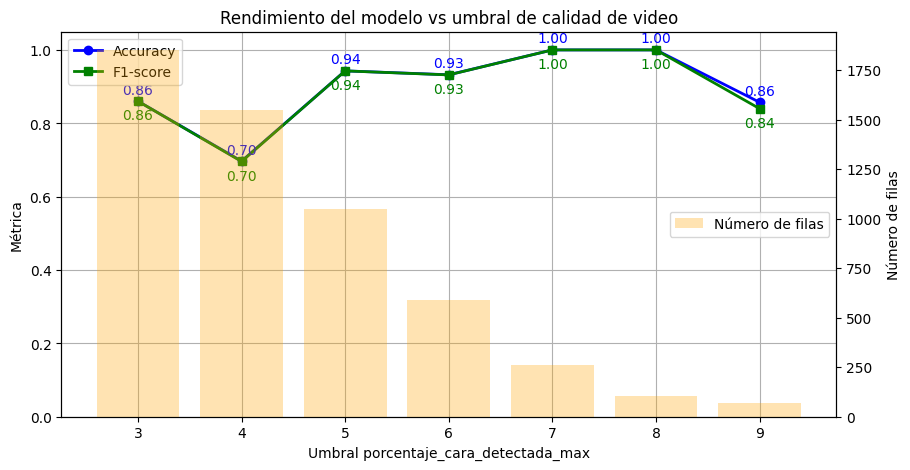

In [ ]:
plot_rendimiento_vs_calidad_video(model5, df_model1,selected_features)

Mayor capacidad de generalización

El Modelo 5 mostró un rendimiento alto y estable en distintos niveles de calidad del dato. A pesar de experimentar una ligera disminución en su rendimiento en escenarios intermedios, fue capaz de recuperarse y mantener métricas elevadas, lo que demuestra una mejor capacidad de adaptación a la variabilidad natural presente en los datos de video reales.

Buen rendimiento en condiciones reales

Aunque el modelo fue entrenado sobre un subconjunto más restringido y con menor imputación, sus resultados iniciales fueron superiores a los del Modelo 4, incluso ante segmentos con niveles moderados de pérdida de datos. Esto demuestra que el Modelo 5 no depende exclusivamente de datos perfectos, siendo más adecuado para entornos reales donde la calidad de video o la completitud de datos puede ser variable.

Mejor discriminación global

El Modelo 5 obtuvo un AUC de 0.7 en la curva ROC, lo que indica una capacidad de discriminación adecuada entre clases. Su rendimiento se mantiene robusto frente a variaciones en el umbral de calidad facial, lo que refuerza su aplicabilidad práctica en situaciones heterogéneas.

Menor riesgo de sobreajuste

Al haber sido entrenado con un conjunto de datos más representativo y con menos imputación, el Modelo 5 presenta menor probabilidad de haber aprendido patrones artificiales derivados del preprocesamiento. Esto favorece su validez externa y su capacidad para generalizar correctamente en nuevos contextos.

Guardo igualmente los datos de los 2 modelos pues en produccion, puedo dependiendo del % de frames usar uno u otro

In [ ]:
from math import exp
def artifacts_modelo(model,data,selected_features):

    X_train, X_test, y_train, y_test = train_test_split(data[selected_features],
                                                    data['tipo_comunicador'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = data['tipo_comunicador'])

    #guardar características del modelo para puesta en produccion
    features = X_train.columns.tolist()

    feat_importances = pd.DataFrame({
        "feature": features,
        "importance": model.feature_importances_
    })
    stats = X_train.describe().T[["mean", "std", "min", "max"]]
    feat_importances = feat_importances.merge(stats, left_on="feature", right_index=True)
    feat_importances.sort_values(by="importance", ascending=False, inplace=True)
    train_accuracy = train_accuracy = accuracy_score(y_train, model.predict(X_train))

    import shap
    explainer = shap.TreeExplainer(model, X_train)
    ideales_globales = X_train[y_train==1].mean().to_dict()

    winsor_limits =pd.read_csv( os.path.join(folder_path, "winsor_limits.csv"))


    # Calcular medianas
    num_cols=data.select_dtypes(include='number').columns

    medianas_df = data[num_cols].median()

    # Añadir a artifacts

    artifacts={}
    artifacts["Medianas_df"]= medianas_df
    artifacts["winsor_limits"]= winsor_limits
    artifacts["model"] = model
    artifacts["features"]= features
    artifacts["explainer"]= explainer
    artifacts["feature_importances"]= feat_importances
    artifacts["stats_model"]= stats
    artifacts["train_accuracy"]= train_accuracy
    artifacts["params"] = model.get_params()
    artifacts["ideales_globales"]= ideales_globales


    return artifacts

artifacts_modelo4=artifacts_modelo(model4,df_model1,selected_features)

joblib.dump(artifacts_modelo4, os.path.join(folder_path, f"randomforest_artifacts_modelo4.pkl"))
print(f"artifacts_modelo4 guardados en:", os.path.join(folder_path, f"randomforest_artifacts_modelo4.pkl"))

artifacts_modelo4 guardados en: /content/drive/MyDrive/TFM_Analisis_Multimodal_Comunicacion/data/folder_path/randomforest_artifacts_modelo4.pkl


In [ ]:
artifacts_modelo5=artifacts_modelo(model5,df_model_calidad4,selected_features)

joblib.dump(artifacts_modelo5, os.path.join(model_path, f"randomforest_artifacts_modelo5.pkl"))
print(f"artifacts_modelo5 guardados en:", os.path.join(model_path, f"randomforest_artifacts_modelo5.pkl"))

artifacts_modelo5 guardados en: /content/drive/MyDrive/TFM_Analisis_Multimodal_Comunicacion/models/randomforest_artifacts_modelo5.pkl



📊 Iniciando análisis SHAP para: modelo4


100%|===================| 3703/3704 [03:24<00:00]       


=== Importancias SHAP (TODAS las features) — clase: 0 ===
                         feature  mean_SHAP_prob  abs_mean_SHAP_prob
8                     rms_brazos       -0.006527            0.040641
2   impacto_anecdotas_detectadas       -0.006511            0.032452
5                  rms_mean_mean       -0.005226            0.032299
16                duracion_video       -0.004704            0.029543
3                      anecdotas       -0.000620            0.026081
0             claridad_oraciones       -0.002948            0.022530
10                  zcr_mean_min       -0.000448            0.022234
11                       yaw_max       -0.001894            0.021586
12                     pitch_min       -0.000252            0.021432
9                       pmm_mean        0.002773            0.019819
13           apertura_brazos_var       -0.001967            0.018611
22       emocion_audio_calm_mean       -0.001473            0.016978
6                   rms_mean_var       -0.00

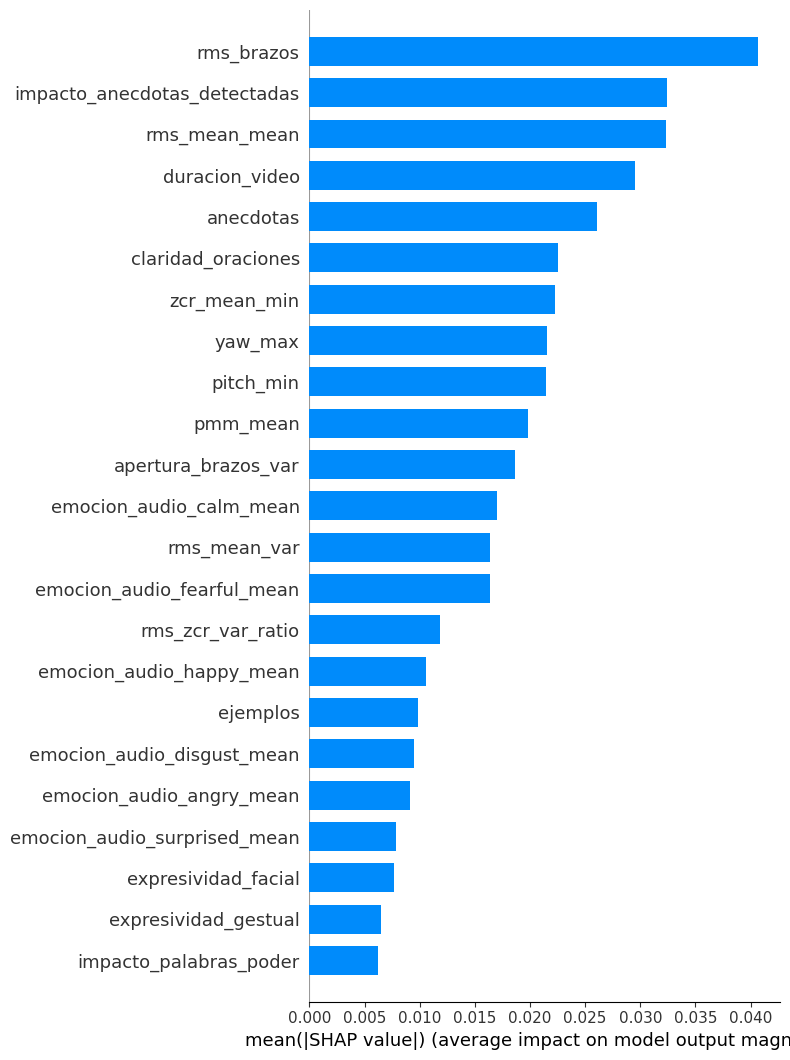

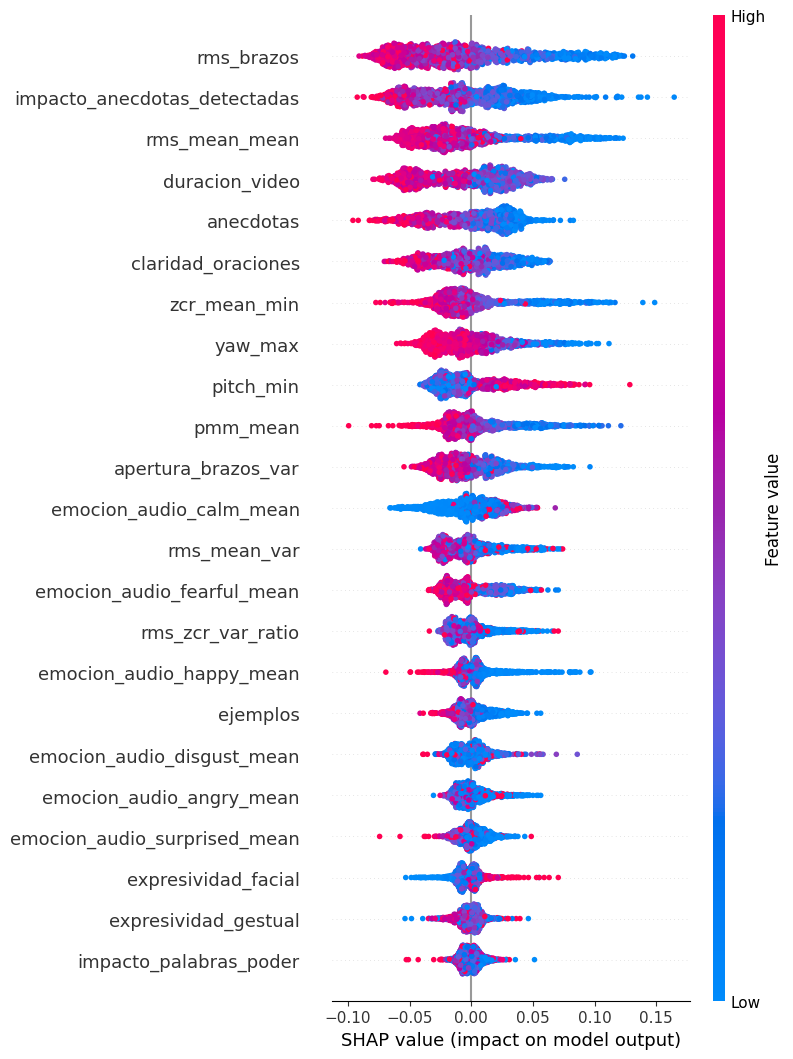


Resumen SHAP — clase: 1


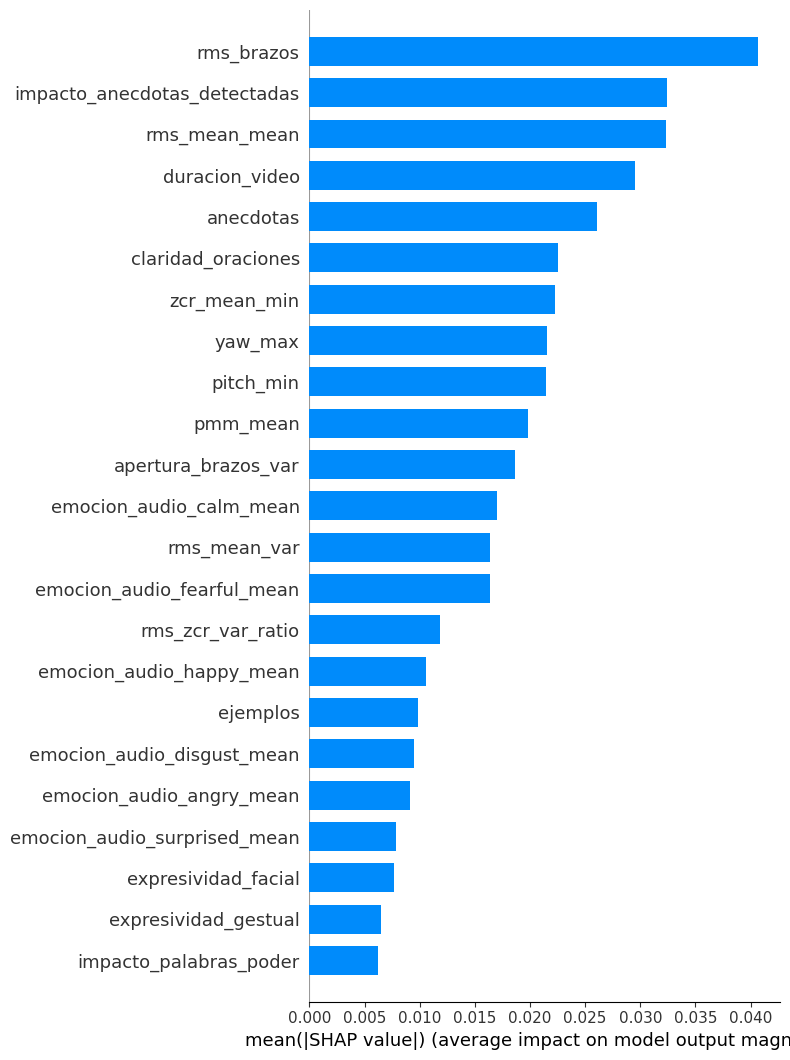

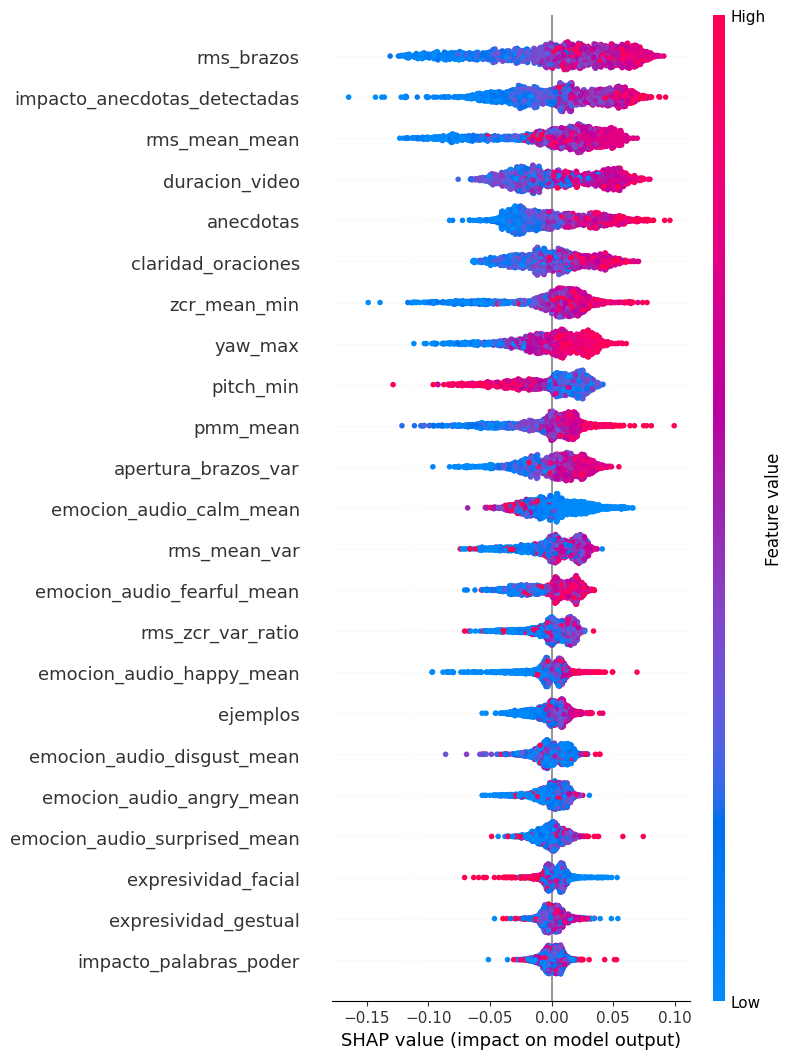

In [ ]:
# ===== SHAP completo para RandomForestClassifier (binario o multiclase) =====
# Muestra TODAS las features en tablas y gráficos, y exporta CSV por clase.
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

import shap
import pandas as pd
import numpy as np

def shap_analysis_tree_model(model, df, selected_features, name="modelo", sample_size=200, return_artifacts=True):
    """
    Realiza análisis SHAP completo para modelos basados en árboles (output: probabilidad).

    Parámetros:
    -----------
    model : objeto
        Modelo entrenado (e.g. RandomForest, XGBoost, LightGBM)
    df : pd.DataFrame
        DataFrame con todas las features (ya preprocesado)
    selected_features : list
        Lista de nombres de columnas usadas por el modelo
    name : str
        Nombre del modelo (solo para trazabilidad)
    sample_size : int
        Número de muestras para el background SHAP (por defecto 200)
    return_artifacts : bool
        Si True, devuelve diccionario con tablas SHAP por clase

    Retorna:
    --------
    artifacts : dict (si return_artifacts=True)
        Diccionario con DataFrames de importancia SHAP por clase
    """
    print(f"\n📊 Iniciando análisis SHAP para: {name}")

    # --- Configuración de datos ---
    X_df = df[selected_features].copy()
    n_features = len(X_df.columns)
    classes = list(model.classes_)
    n_classes = len(classes)

    # --- Background para SHAP ---
    bg = X_df.sample(min(sample_size, len(X_df)), random_state=0)

    # --- Explainer SHAP ---
    explainer = shap.Explainer(
        model,
        bg,
        algorithm="tree",
        feature_perturbation="interventional",
        model_output="probability"
    )

    # --- Calcular valores SHAP ---
    sv = explainer(X_df, check_additivity=False)

    # --- Parseo robusto por clase ---
    def shap_per_class(sv_obj, n_features, classes):
        if isinstance(sv_obj, (list, tuple)):
            assert len(sv_obj) == len(classes)
            out = {}
            for i, c in enumerate(classes):
                arr = np.asarray(getattr(sv_obj[i], "values", sv_obj[i]))
                if arr.ndim == 3 and arr.shape[1] == 1:
                    arr = arr[:, 0, :]
                assert arr.ndim == 2 and arr.shape[1] == n_features
                out[c] = arr
            return out

        vals = np.asarray(getattr(sv_obj, "values", sv_obj))
        if vals.ndim == 2:
            c = classes[1] if len(classes) == 2 else classes[0]
            return {c: vals}
        if vals.ndim == 3:
            if vals.shape[1] == len(classes) and vals.shape[2] == n_features:
                pass
            elif vals.shape[1] == n_features and vals.shape[2] == len(classes):
                vals = np.transpose(vals, (0, 2, 1))
            else:
                raise ValueError(f"Forma 3D inesperada: {vals.shape}")
            out = {classes[i]: vals[:, i, :] for i in range(len(classes))}
            return out

        raise ValueError(f"Forma SHAP no soportada: {vals.shape}")

    sv_per_class = shap_per_class(sv, n_features=n_features, classes=classes)

    # --- Crear tablas de importancia por clase ---
    dir_tables = {}
    for c, mat in sv_per_class.items():
        df_imp = pd.DataFrame({
            "feature": X_df.columns,
            "mean_SHAP_prob": mat.mean(axis=0),
            "abs_mean_SHAP_prob": np.abs(mat).mean(axis=0)
        }).sort_values("abs_mean_SHAP_prob", ascending=False)
        dir_tables[c] = df_imp

    # --- Mostrar tablas en consola ---
    for c in sv_per_class.keys():
        print(f"\n=== Importancias SHAP (TODAS las features) — clase: {c} ===")
        print(dir_tables[c][["feature", "mean_SHAP_prob", "abs_mean_SHAP_prob"]])

    # --- Mostrar gráficos por clase ---
    max_disp = n_features
    if len(sv_per_class) == 1:
        mat = next(iter(sv_per_class.values()))
        shap.summary_plot(mat, X_df, plot_type="bar", max_display=max_disp)
        shap.summary_plot(mat, X_df, max_display=max_disp)
    else:
        for c, mat in sv_per_class.items():
            print(f"\nResumen SHAP — clase: {c}")
            shap.summary_plot(mat, X_df, plot_type="bar", max_display=max_disp, show=True)
            shap.summary_plot(mat, X_df, max_display=max_disp, show=True)


shap_analysis_tree_model(model5, df_model1, selected_features, name="modelo4")


In [ ]:
frases_por_feature = {
    "claridad_oraciones": {
        "descripcion": "Claridad sintáctica y gramatical del texto. Frases bien estructuradas facilitan la comprensión.",
        "mas_positivo": "Tus frases son más claras que el promedio y esto mejora tu comunicación.",
        "mas_negativo": "Aunque tus frases son claras, su exceso de estructura podría sonar artificial o recitada.",
        "menos_positivo": "A pesar de usar estructuras menos claras, estás comunicando eficazmente.",
        "menos_negativo": "La falta de claridad en tus frases dificulta que el mensaje se entienda bien. Revisa la estructura.",
        "alineado": "La claridad de tus oraciones está en el nivel óptimo para una buena comunicación."
    },
    "impacto_palabras_poder": {
        "descripcion": "Uso de palabras con carga persuasiva, emocional o enfática.",
        "mas_positivo": "El uso de palabras poderosas mejora tu impacto comunicativo.",
        "mas_negativo": "El exceso de palabras cargadas puede parecer exagerado o forzado. Usa solo donde refuerce el mensaje.",
        "menos_positivo": "Usas pocas palabras poderosas, pero en tu caso eso mejora la naturalidad.",
        "menos_negativo": "Tu discurso puede beneficiarse de un lenguaje más persuasivo o emocional.",
        "alineado": "Tu uso de palabras poderosas es adecuado y bien equilibrado."
    },
    "impacto_anecdotas_detectadas": {
        "descripcion": "Impacto estimado de las anécdotas utilizadas en el discurso.",
        "mas_positivo": "Tus anécdotas están generando un impacto muy positivo en la audiencia.",
        "mas_negativo": "El exceso de anécdotas puede desviar la atención del mensaje central.",
        "menos_positivo": "Aunque usas pocas anécdotas, tu mensaje mantiene un impacto fuerte.",
        "menos_negativo": "Podrías reforzar tu mensaje incluyendo ejemplos o anécdotas personales.",
        "alineado": "El uso e impacto de tus anécdotas está en el punto justo."
    },
    "anecdotas": {
        "descripcion": "Número o presencia de anécdotas personales o ejemplificadoras.",
        "mas_positivo": "Incluir anécdotas mejora tu cercanía con la audiencia.",
        "mas_negativo": "Demasiadas anécdotas pueden diluir el mensaje principal.",
        "menos_positivo": "Tu estilo directo sin muchas anécdotas está funcionando.",
        "menos_negativo": "Podrías conectar mejor con el público usando más ejemplos personales.",
        "alineado": "Tu uso de anécdotas es equilibrado."
    },
    "ejemplos": {
        "descripcion": "Cantidad de ejemplos concretos usados para explicar ideas.",
        "mas_positivo": "Los ejemplos que usas están reforzando tu mensaje.",
        "mas_negativo": "Usar demasiados ejemplos puede distraer o parecer redundante.",
        "menos_positivo": "La simplicidad de tu discurso sin ejemplos está ayudando a enfocarse.",
        "menos_negativo": "Agregar ejemplos ayudaría a clarificar ideas abstractas.",
        "alineado": "Usas ejemplos en la cantidad adecuada."
    },
    "rms_mean_mean": {
        "descripcion": "Energía vocal media. Relacionada con el volumen general.",
        "mas_positivo": "Tu volumen transmite seguridad y presencia.",
        "mas_negativo": "Hablar demasiado fuerte puede parecer agresivo o ansioso.",
        "menos_positivo": "Tu tono suave genera cercanía y calma.",
        "menos_negativo": "Tu volumen bajo puede dificultar la comprensión. Intenta proyectar más.",
        "alineado": "Tu energía vocal está en el rango óptimo."
    },
    "rms_mean_var": {
        "descripcion": "Variabilidad de energía vocal. Indica cambios de volumen que aportan expresividad.",
        "mas_positivo": "Tienes una buena modulación de volumen que mantiene el interés.",
        "mas_negativo": "Demasiadas variaciones pueden parecer caóticas o desorganizadas.",
        "menos_positivo": "Tu estilo plano está funcionando por ser muy claro y directo.",
        "menos_negativo": "Mayor modulación de volumen podría hacer tu discurso más expresivo.",
        "alineado": "Tu variación de energía está equilibrada."
    },
    "rms_zcr_var_ratio": {
        "descripcion": "Relación entre variabilidad de energía y ritmo. Indicador de control vocal.",
        "mas_positivo": "Controlas bien la relación entre energía y ritmo de habla.",
        "mas_negativo": "La relación entre ritmo y energía puede resultar confusa o acelerada.",
        "menos_positivo": "Aunque tu ritmo es más pausado, está ayudando a la claridad.",
        "menos_negativo": "Podrías mejorar el impacto controlando mejor ritmo y volumen juntos.",
        "alineado": "Tienes buen equilibrio entre ritmo y energía."
    },
    "rms_brazos": {
        "descripcion": "Coordinación entre voz y movimiento de brazos.",
        "mas_positivo": "Tu expresividad gestual está bien alineada con tu voz.",
        "mas_negativo": "Gesticulas mucho en momentos que no aportan al mensaje.",
        "menos_positivo": "Tu estilo sobrio ayuda a mantener el foco.",
        "menos_negativo": "Más gestos coordinados con tu voz pueden hacerte más persuasivo.",
        "alineado": "Tu coordinación entre voz y gestos es adecuada."
    },
    "pmm_mean": {
        "descripcion": "Velocidad de habla (palabras por minuto).",
        "mas_positivo": "Tu velocidad transmite dinamismo y energía.",
        "mas_negativo": "Hablas demasiado rápido, lo que puede dificultar la comprensión. Intenta bajar el ritmo.",
        "menos_positivo": "Hablas más lento, lo cual da claridad y pausa.",
        "menos_negativo": "Tu ritmo de habla es demasiado bajo y puede perder el interés. Aumenta ligeramente.",
        "alineado": "Tu ritmo de habla es adecuado para mantener la atención."
    },
    "zcr_mean_min": {
        "descripcion": "Duración de las pausas prolongadas en el discurso.",
        "mas_positivo": "Usas pausas efectivas que refuerzan el mensaje.",
        "mas_negativo": "Demasiadas pausas largas pueden hacer que el discurso pierda ritmo.",
        "menos_positivo": "Tu estilo continuo mantiene la fluidez.",
        "menos_negativo": "Podrías usar pausas estratégicas para dar énfasis.",
        "alineado": "El uso de pausas está equilibrado."
    },
    "yaw_max": {
        "descripcion": "Movimiento máximo de la cabeza (horizontal).",
        "mas_positivo": "Tu movimiento de cabeza aporta naturalidad y conexión.",
        "mas_negativo": "Mover la cabeza en exceso puede parecer inseguridad o nerviosismo.",
        "menos_positivo": "Tu estabilidad proyecta seguridad.",
        "menos_negativo": "Un poco más de movimiento puede mejorar la expresividad.",
        "alineado": "Tu movimiento de cabeza es natural y efectivo."
    },
    "pitch_min": {
    "descripcion": "Inclinación vertical mínima de la cabeza (pitch). Indica cuánto baja la cabeza durante el segmento.",
    "mas_positivo": "Inclinaste la cabeza ligeramente hacia abajo en algunos momentos, lo que puede transmitir atención o reflexión.",
    "mas_negativo": "Una inclinación excesiva hacia abajo puede dar una imagen de desconexión o inseguridad.",
    "menos_positivo": "Mantener la cabeza erguida ayuda a transmitir seguridad y conexión visual.",
    "menos_negativo": "Poca variación en la inclinación puede hacer que tu expresividad corporal sea limitada.",
    "alineado": "Tu postura de cabeza mantiene un buen equilibrio entre naturalidad y expresividad."
    },
    "apertura_brazos_var": {
        "descripcion": "Variación en la apertura de brazos. Relacionada con gestualidad abierta.",
        "mas_positivo": "Usas tus brazos con variabilidad y expresividad.",
        "mas_negativo": "Demasiada gestualidad puede distraer si no está alineada con el mensaje.",
        "menos_positivo": "Tu sobriedad en gestos favorece la claridad.",
        "menos_negativo": "Podrías abrir más tus gestos para conectar mejor con el público.",
        "alineado": "Tienes una gestualidad equilibrada."
    },
    "expresividad_facial": {
        "descripcion": "Nivel de expresividad en el rostro.",
        "mas_positivo": "Tu rostro comunica emoción y refuerza el mensaje.",
        "mas_negativo": "Podrías estar sobreactuando, lo que reduce credibilidad.",
        "menos_positivo": "Tu expresión neutra ayuda a enfocarse en el contenido.",
        "menos_negativo": "Más expresividad facial puede mejorar la conexión emocional.",
        "alineado": "Tu expresividad facial es adecuada y coherente."
    },
    "expresividad_gestual": {
        "descripcion": "Expresividad corporal general.",
        "mas_positivo": "Tu lenguaje corporal transmite confianza.",
        "mas_negativo": "Demasiada gesticulación puede parecer descontrol.",
        "menos_positivo": "Tu sobriedad gestual da serenidad.",
        "menos_negativo": "Un poco más de gestualidad daría más fuerza a tu mensaje.",
        "alineado": "Tu lenguaje corporal está bien ajustado."
    },
    "duracion_video": {
        "descripcion": "Duración total del video analizado.",
        "mas_positivo": "Has mantenido la atención durante un video largo, lo que es un logro.",
        "mas_negativo": "Un discurso demasiado largo puede perder efectividad.",
        "menos_positivo": "Tu discurso breve fue conciso y directo.",
        "menos_negativo": "Podrías extender un poco más el contenido para reforzar tus ideas.",
        "alineado": "La duración es adecuada al tipo de mensaje."
    },
    "emocion_audio_happy_mean": {
        "descripcion": "Promedio de emoción de felicidad detectada en el audio.",
        "mas_positivo": "Tu entusiasmo es contagioso y mejora la conexión.",
        "mas_negativo": "Un exceso de entusiasmo puede sonar artificial.",
        "menos_positivo": "Tu tono serio aporta profesionalismo.",
        "menos_negativo": "Podrías parecer desmotivado. Intenta mostrar más entusiasmo.",
        "alineado": "Transmitiste un nivel adecuado de entusiasmo."
    },
    "emocion_audio_fearful_mean": {
        "descripcion": "Promedio de emoción de miedo detectado en el audio.",
        "mas_positivo": "Una ligera tensión añade humanidad al mensaje.",
        "mas_negativo": "Transmitir demasiado miedo puede generar inseguridad en la audiencia.",
        "menos_positivo": "Tu tono seguro es adecuado para este contexto.",
        "menos_negativo": "Puede que tu estilo suene insensible. Mostrar vulnerabilidad puede conectar.",
        "alineado": "Tu tono emocional está equilibrado."
    },
    "emocion_audio_angry_mean": {
        "descripcion": "Promedio de emoción de enojo detectado en el audio.",
        "mas_positivo": "Transmites firmeza, lo cual aporta convicción.",
        "mas_negativo": "Podrías sonar demasiado agresivo. Modula tu tono.",
        "menos_positivo": "Tu serenidad transmite confianza.",
        "menos_negativo": "Falta intensidad en tu tono. Usa más energía si quieres impactar.",
        "alineado": "Transmitiste una intensidad emocional adecuada."
    },
    "emocion_audio_surprised_mean": {
        "descripcion": "Promedio de emoción de sorpresa detectada en el audio.",
        "mas_positivo": "Tu expresividad genera interés y sorpresa.",
        "mas_negativo": "Un tono demasiado sorprendido puede parecer exagerado.",
        "menos_positivo": "Tu tono neutro está aportando seriedad.",
        "menos_negativo": "Podrías generar más interés mostrando mayor sorpresa emocional.",
        "alineado": "El nivel de expresividad está bien regulado."
    },
    "emocion_audio_disgust_mean": {
        "descripcion": "Promedio de emoción de desagrado detectado en el audio.",
        "mas_positivo": "Tu rechazo emocional comunica una postura firme.",
        "mas_negativo": "El tono de desagrado puede generar rechazo en la audiencia.",
        "menos_positivo": "Tu tono neutro evita juicios innecesarios.",
        "menos_negativo": "Podrías parecer indiferente. Mostrar emoción refuerza tu mensaje.",
        "alineado": "Transmitiste lo justo de crítica o rechazo emocional."
    },
    "emocion_audio_calm_mean": {
        "descripcion": "Promedio de emoción de calma detectado en el audio.",
        "mas_positivo": "Tu calma transmite seguridad y control.",
        "mas_negativo": "Demasiada calma puede restar energía o entusiasmo.",
        "menos_positivo": "Tu energía transmite motivación.",
        "menos_negativo": "Un tono muy tenso podría generar incomodidad. Relájate un poco más.",
        "alineado": "Tu nivel de calma es adecuado para tu estilo."
    }
}
randomforest_artifacts_modelo5 =joblib.load(os.path.join(model_path, "randomforest_artifacts_modelo5.pkl"))
randomforest_artifacts_modelo5['frases_por_feature']=frases_por_feature
joblib.dump(randomforest_artifacts_modelo5, os.path.join(model_path, "randomforest_artifacts_modelo5.pkl"))
randomforest_artifacts_modelo4 =joblib.load(os.path.join(model_path, "randomforest_artifacts_modelo4.pkl"))
randomforest_artifacts_modelo4['frases_por_feature']=frases_por_feature
joblib.dump(randomforest_artifacts_modelo4, os.path.join(model_path, "randomforest_artifacts_modelo4.pkl"))



['/content/drive/MyDrive/TFM_Analisis_Multimodal_Comunicacion/models/randomforest_artifacts_modelo4.pkl']

https://ted.com/talks/estelle_gibson_the_true_cost_of_financial_dependence
🎯 Nivel de comunicación según el análisis realizado: 0.847
🔵 Nivel de comunicador **alto**

🔷 FEEDBACK GLOBAL
🟢 En general, las características del orador favorecen positivamente la predicción del modelo.




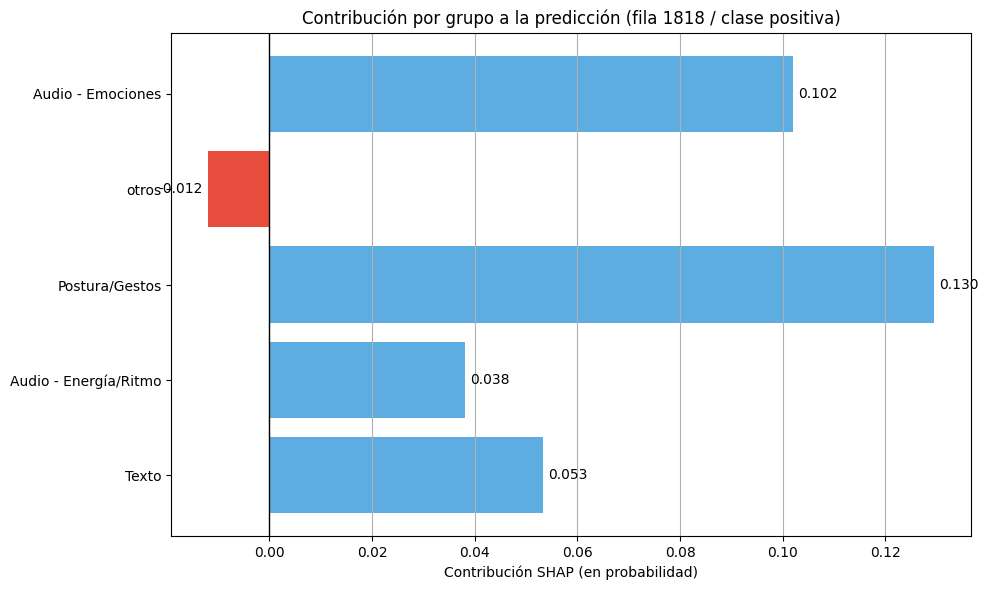


🟩 FEEDBACK — Grupo: Texto
🔵 El grupo **Texto** tiene una influencia positiva destacada en la predicción.



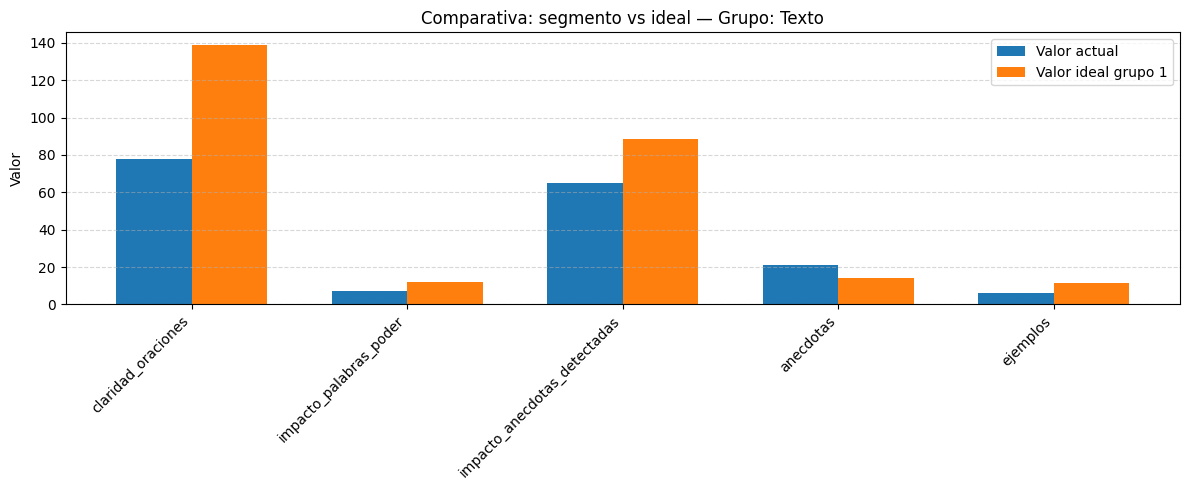

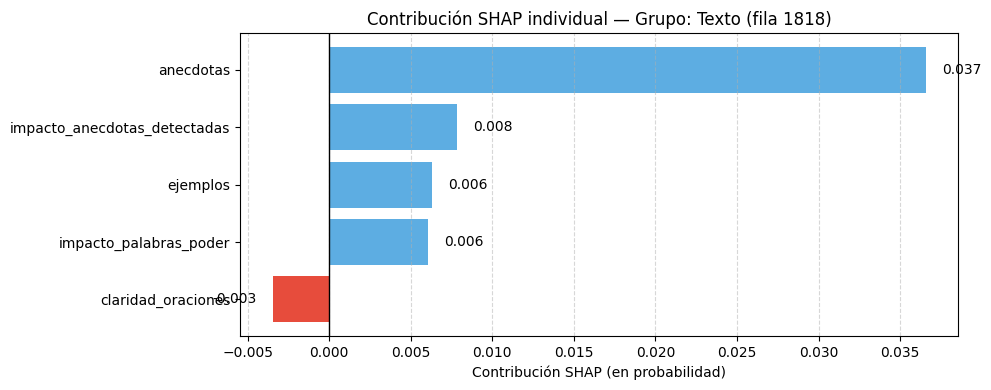

   🔹 claridad_oraciones: Claridad sintáctica y gramatical del texto. Frases bien estructuradas facilitan la comprensión.
Tiene un valor de `78.00` frente a un ideal de `138.70` (diferencia `-60.70`). SHAP=-0.003. La falta de claridad en tus frases dificulta que el mensaje se entienda bien. Revisa la estructura.

   🔹 impacto_palabras_poder: Uso de palabras con carga persuasiva, emocional o enfática.
Tiene un valor de `7.00` frente a un ideal de `11.92` (diferencia `-4.92`). SHAP=+0.006. Usas pocas palabras poderosas, pero en tu caso eso mejora la naturalidad.

   🔹 impacto_anecdotas_detectadas: Impacto estimado de las anécdotas utilizadas en el discurso.
Tiene un valor de `65.00` frente a un ideal de `88.68` (diferencia `-23.68`). SHAP=+0.008. Aunque usas pocas anécdotas, tu mensaje mantiene un impacto fuerte.

   🔹 anecdotas: Número o presencia de anécdotas personales o ejemplificadoras.
Tiene un valor de `21.00` frente a un ideal de `14.01` (diferencia `+6.99`). SHAP=+0.037. Incluir 

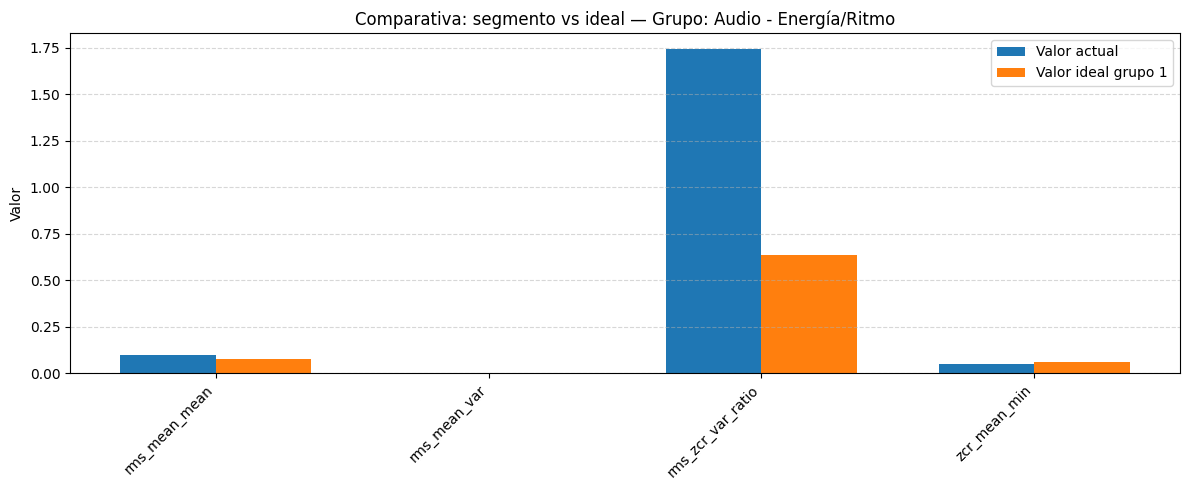

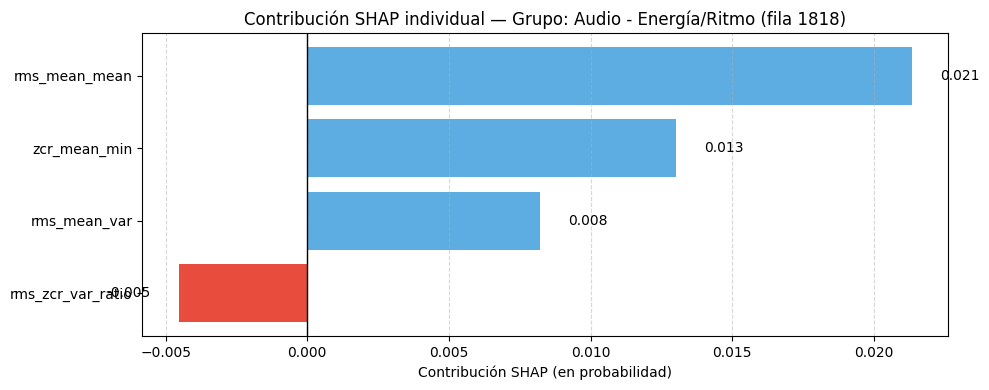

   🔹 rms_mean_mean: Energía vocal media. Relacionada con el volumen general.
Tiene un valor de `0.10` frente a un ideal de `0.08` (diferencia `+0.02`). SHAP=+0.021. Tu energía vocal está en el rango óptimo.

   🔹 rms_mean_var: Variabilidad de energía vocal. Indica cambios de volumen que aportan expresividad.
Tiene un valor de `0.00` frente a un ideal de `0.00` (diferencia `+0.00`). SHAP=+0.008. Tu variación de energía está equilibrada.

   🔹 rms_zcr_var_ratio: Relación entre variabilidad de energía y ritmo. Indicador de control vocal.
Tiene un valor de `1.74` frente a un ideal de `0.64` (diferencia `+1.11`). SHAP=-0.005. La relación entre ritmo y energía puede resultar confusa o acelerada.

   🔹 zcr_mean_min: Duración de las pausas prolongadas en el discurso.
Tiene un valor de `0.05` frente a un ideal de `0.06` (diferencia `-0.01`). SHAP=+0.013. El uso de pausas está equilibrado.


🟩 FEEDBACK — Grupo: Audio - Emociones
🔵 El grupo **Audio - Emociones** tiene una influencia positiva dest

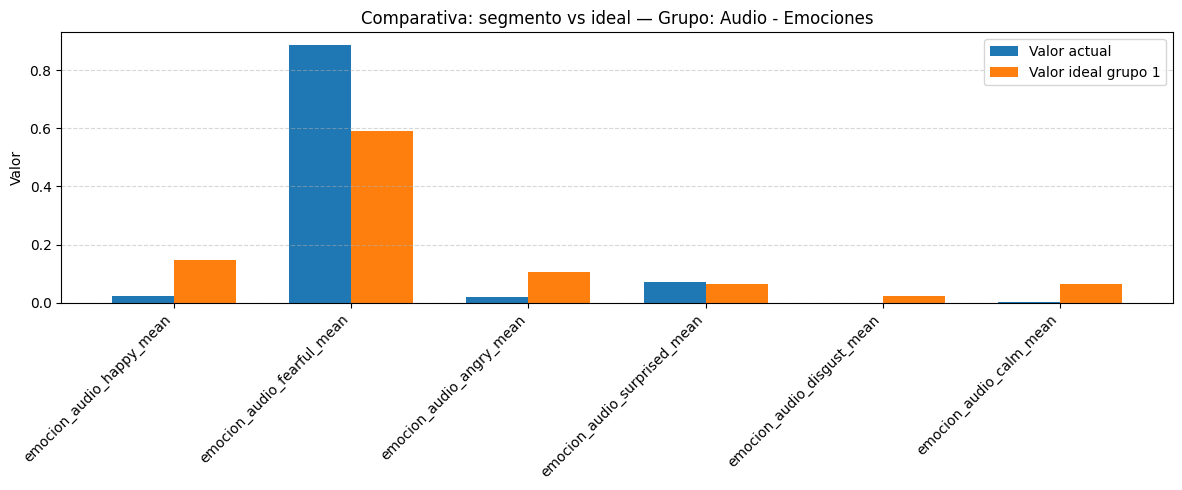

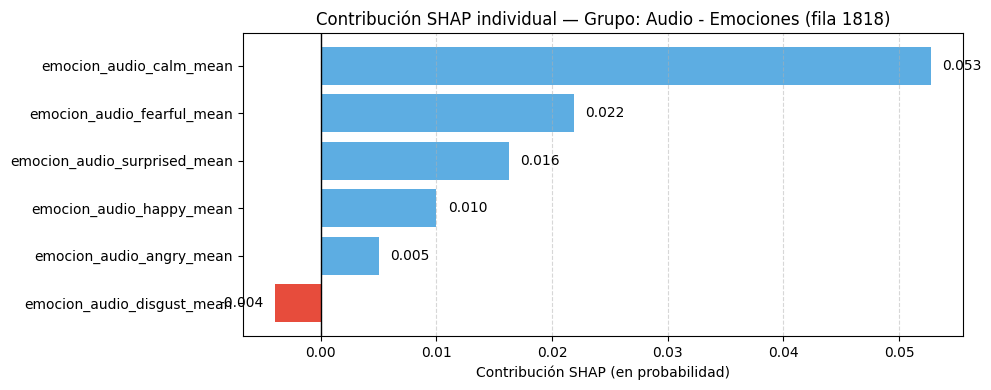

   🔹 emocion_audio_happy_mean: Promedio de emoción de felicidad detectada en el audio.
Tiene un valor de `0.02` frente a un ideal de `0.15` (diferencia `-0.13`). SHAP=+0.010. Tu tono serio aporta profesionalismo.

   🔹 emocion_audio_fearful_mean: Promedio de emoción de miedo detectado en el audio.
Tiene un valor de `0.89` frente a un ideal de `0.59` (diferencia `+0.29`). SHAP=+0.022. Una ligera tensión añade humanidad al mensaje.

   🔹 emocion_audio_angry_mean: Promedio de emoción de enojo detectado en el audio.
Tiene un valor de `0.02` frente a un ideal de `0.10` (diferencia `-0.09`). SHAP=+0.005. Tu serenidad transmite confianza.

   🔹 emocion_audio_surprised_mean: Promedio de emoción de sorpresa detectada en el audio.
Tiene un valor de `0.07` frente a un ideal de `0.06` (diferencia `+0.01`). SHAP=+0.016. El nivel de expresividad está bien regulado.

   🔹 emocion_audio_disgust_mean: Promedio de emoción de desagrado detectado en el audio.
Tiene un valor de `0.00` frente a un ideal de 

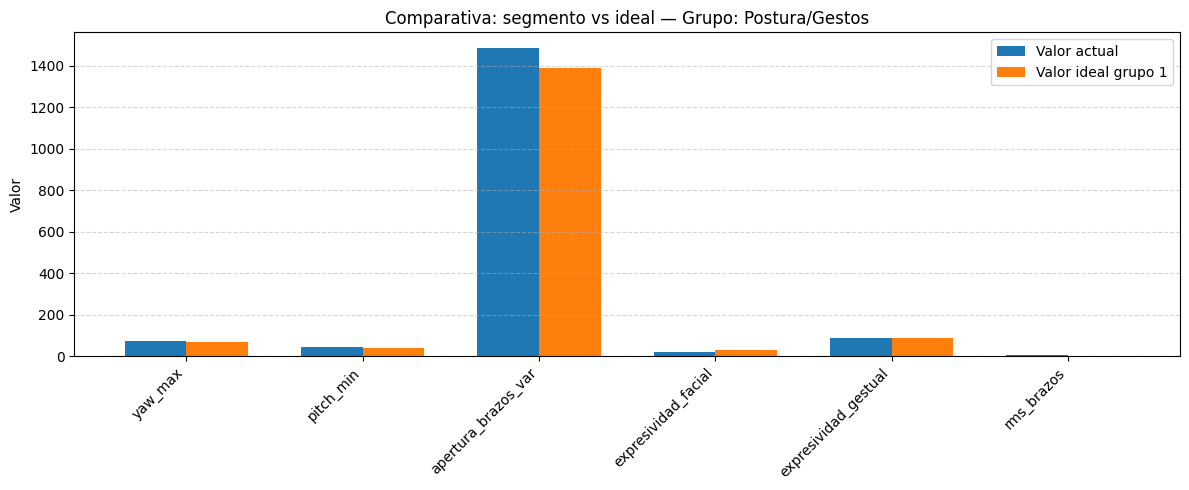

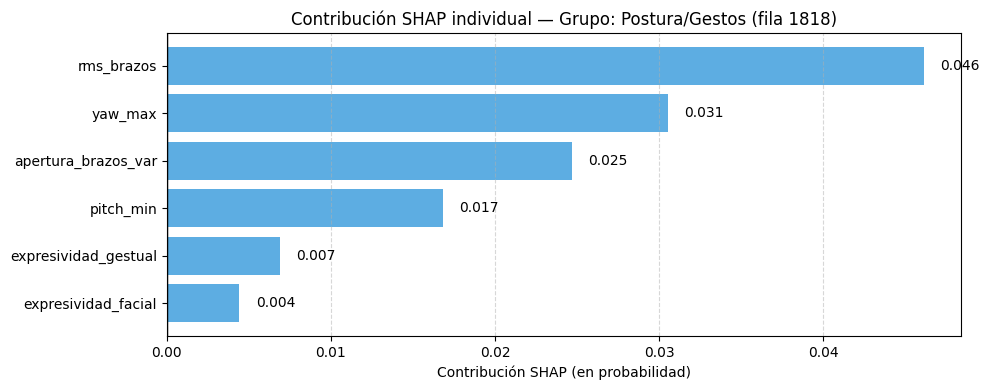

   🔹 yaw_max: Movimiento máximo de la cabeza (horizontal).
Tiene un valor de `71.66` frente a un ideal de `67.46` (diferencia `+4.20`). SHAP=+0.031. Tu movimiento de cabeza aporta naturalidad y conexión.

   🔹 pitch_min: Inclinación vertical mínima de la cabeza (pitch). Indica cuánto baja la cabeza durante el segmento.
Tiene un valor de `46.22` frente a un ideal de `41.51` (diferencia `+4.71`). SHAP=+0.017. Inclinaste la cabeza ligeramente hacia abajo en algunos momentos, lo que puede transmitir atención o reflexión.

   🔹 apertura_brazos_var: Variación en la apertura de brazos. Relacionada con gestualidad abierta.
Tiene un valor de `1485.72` frente a un ideal de `1388.65` (diferencia `+97.07`). SHAP=+0.025. Usas tus brazos con variabilidad y expresividad.

   🔹 expresividad_facial: Nivel de expresividad en el rostro.
Tiene un valor de `19.84` frente a un ideal de `28.29` (diferencia `-8.45`). SHAP=+0.004. Tu expresión neutra ayuda a enfocarse en el contenido.

   🔹 expresividad_gestua

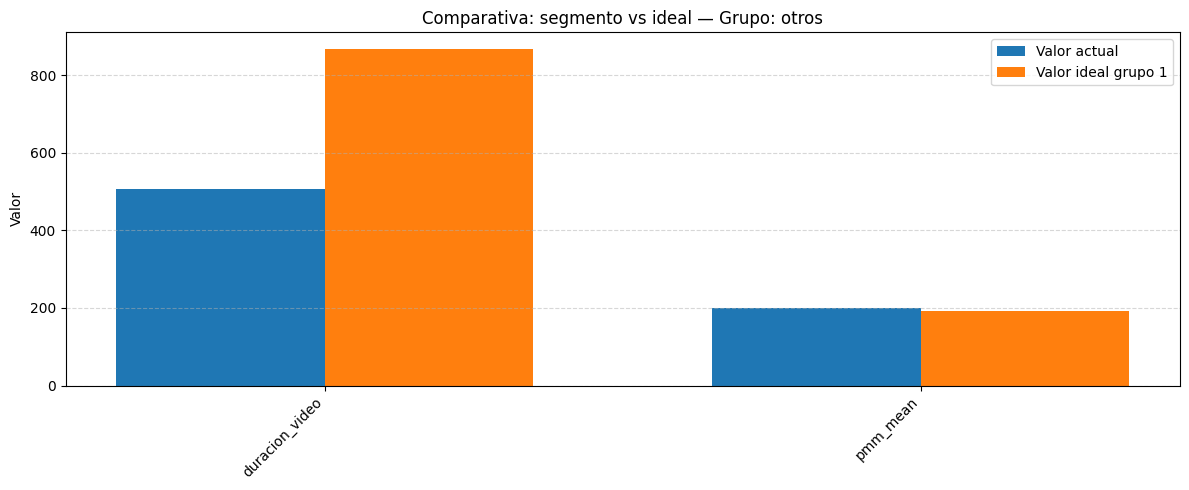

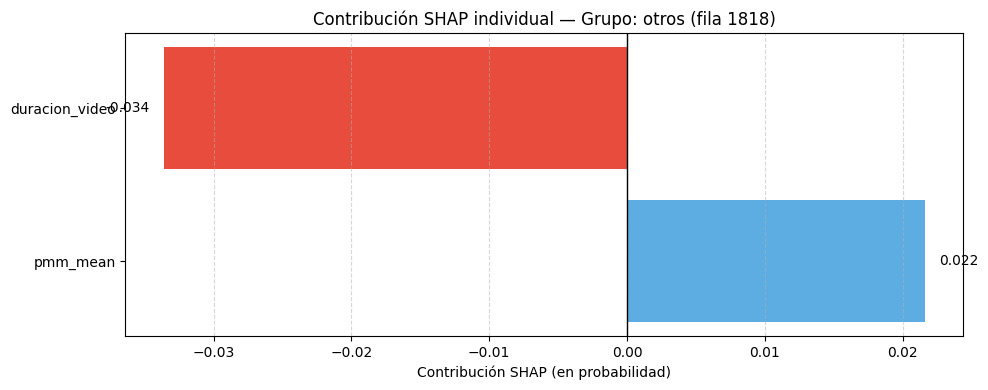

   🔹 duracion_video: Duración total del video analizado.
Tiene un valor de `506.91` frente a un ideal de `867.00` (diferencia `-360.08`). SHAP=-0.034. Podrías extender un poco más el contenido para reforzar tus ideas.

   🔹 pmm_mean: Velocidad de habla (palabras por minuto).
Tiene un valor de `200.73` frente a un ideal de `192.61` (diferencia `+8.11`). SHAP=+0.022. Tu velocidad transmite dinamismo y energía.



In [ ]:
# ==========================================================
# EXPLICACIÓN LOCAL AGRUPADA POR TIPO DE FEATURES (COLAB)
# Con SHAP + RandomForestClassifier y artifacts existentes
# ==========================================================
import os, random, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import shap

# -----------------------------
# 1) Configuración
# -----------------------------
# (A) Ruta donde guardaste los artifacts
#     Si ya tienes folder_path definido, se usa tal cual.
#     Si no, define uno:
# folder_path = "/content"  # <-- ajusta si hace falta

# (B) ¿Qué clase quieres explicar si el modelo es binario?
#    - "predicted": la clase predicha para la fila
#    - "positive": la clase 1 (útil si siempre quieres explicar respecto a 1)
CLASS_CHOICE = "positive"   # "predicted" | "positive"

# (C) ¿Qué índice de fila? Si None -> aleatoria
ROW_INDEX = None

# (D) ¿Explicar sobre todo el dataset o solo test?
#    Si tienes X_test/X_train en el entorno y quieres usar X_test, cambia a:
#    DATA_SOURCE = "all" | "test" | "train"
DATA_SOURCE = "all"

# -----------------------------
# 2) Cargar artifacts + datos
# -----------------------------
artifacts_path = os.path.join(model_path, "randomforest_artifacts_modelo5.pkl")
artifacts = joblib.load(artifacts_path)

model      = artifacts["model"]
explainer  = artifacts["explainer"]          # TreeExplainer guardado
features   = artifacts["features"]          # lista de columnas del modelo
frases_por_feature = artifacts["frases_por_feature"]
ideales_globales = artifacts["ideales_globales"]

# df_model1 debe estar en el entorno; si tuvieras un dataframe distinto,
# ajústalo aquí:
df_estadisticas_segmentos_video=pd.read_csv(os.path.join(folder_path, "df_estadisticas_segmentos_video.csv"))
df_caracteristicas_generales_videos=pd.read_csv(os.path.join(folder_path, "df_videos_caract_texto.csv"))

df_model=df_caracteristicas_generales_videos.merge(df_estadisticas_segmentos_video, on='video_id')
X_all = df_model[features].copy()
y_all= df_model['tipo_comunicador']
url_all=df_model['link']

if DATA_SOURCE == "all":
  X_source = X_all

# Selección de fila
if ROW_INDEX is None:
    i = random.randint(0, len(X_source) - 1)
else:
    i = int(ROW_INDEX)
x_sample = X_source.iloc[[i]]   # mantener DataFrame

url=url_all.iloc[i]
y_sample = y_all.iloc[i]
print(url)

# -----------------------------
# 3) Predicción del modelo
# -----------------------------
probs = model.predict_proba(x_sample)[0]
classes = list(model.classes_)
pred_idx = int(np.argmax(probs))
pred_class = classes[pred_idx]

prob_1 = probs[1]
nivel_comunicador = f"🎯 Nivel de comunicación según el análisis realizado: {prob_1:.3f}"

# Clasificación cualitativa
if prob_1 < 0.20:
    categoria = "🔴 Nivel de comunicador **bajo**"
elif prob_1 < 0.40:
    categoria = "🟠 Nivel de comunicador **medio-bajo**"
elif prob_1 < 0.60:
    categoria = "🟡 Nivel de comunicador **medio**"
elif prob_1 < 0.80:
    categoria = "🟢 Nivel de comunicador **medio-alto**"
else:
    categoria = "🔵 Nivel de comunicador **alto**"

print(nivel_comunicador)
print(categoria)

# -----------------------------
# 4) Obtener SHAP local (robusto a formas)
# -----------------------------
def compute_shap_for_one(explainer, x_df):
    """
    Devuelve un objeto que puede ser shap.Explanation o array/list,
    dependiendo de la versión/Explainer.
    """
    try:
        return explainer(x_df)  # API moderna suele devolver Explanation
    except Exception:
        # Fallback a .shap_values clásico
        return explainer.shap_values(x_df)

sv = compute_shap_for_one(explainer, x_sample)

def to_1d_for_class(sv_obj, features, classes, class_choice, pred_class):
    """
    Normaliza SHAP a un vector 1D (n_features,) para UNA clase.
    Soporta:
      - shap.Explanation con .values de formas (f,), (1,f), (f,c), (c,f),
        (1,f,c), (1,c,f)
      - list por clase
      - ndarray con las formas anteriores
    """
    class_to_idx = {c:i for i,c in enumerate(classes)}
    if class_choice == "positive" and 1 in class_to_idx:
        target_idx = class_to_idx[1]
    elif class_choice == "predicted":
        target_idx = class_to_idx[pred_class]
    else:
        # fallback: predicha
        target_idx = class_to_idx[pred_class]

    # Extraer valores crudos
    arr = np.asarray(getattr(sv_obj, "values", sv_obj))

    # Casos
    if isinstance(sv_obj, (list, tuple)):
        # Lista por clase: tomar directamente la del target
        part = sv_obj[target_idx]
        arr = np.asarray(getattr(part, "values", part))
        if arr.ndim == 2 and arr.shape[0] == 1:  # (1, f)
            arr = arr[0]
        assert arr.ndim == 1 or (arr.ndim == 2 and arr.shape[0] == 1) or (arr.ndim == 2 and arr.shape[1] == len(features)), \
            f"SHAP list forma inesperada: {arr.shape}"
        if arr.ndim == 2 and arr.shape[0] == 1:
            arr = arr[0]
        if arr.ndim == 2 and arr.shape[1] == len(features):
            # (?, f). Si batch=1 -> coger fila 0
            if arr.shape[0] == 1:
                arr = arr[0]
            else:
                raise ValueError("Se esperaba batch=1 para la explicación local.")
        return arr.reshape(-1)

    # Explanation/ndarray
    if arr.ndim == 1 and arr.shape[0] == len(features):
        return arr  # (f,)
    if arr.ndim == 2:
        if arr.shape == (1, len(features)):            # (1,f)
            return arr[0]
        if arr.shape == (len(features), len(classes)):  # (f,c)
            return arr[:, target_idx]
        if arr.shape == (len(classes), len(features)):  # (c,f)
            return arr[target_idx, :]
        raise ValueError(f"Forma SHAP 2D inesperada: {arr.shape}")

    if arr.ndim == 3:
        # Esperamos batch=1
        if arr.shape[0] != 1:
            raise ValueError(f"Se esperaba batch=1, obtuve {arr.shape}")
        if arr.shape[1] == len(features) and arr.shape[2] == len(classes):   # (1,f,c)
            return arr[0, :, target_idx]
        if arr.shape[1] == len(classes) and arr.shape[2] == len(features):   # (1,c,f)
            return arr[0, target_idx, :]
        raise ValueError(f"Forma SHAP 3D inesperada: {arr.shape}")

    raise ValueError(f"Forma SHAP no soportada: {arr.shape}")

shap_val_1d = to_1d_for_class(sv, features, classes, CLASS_CHOICE, pred_class)
assert shap_val_1d.shape[0] == len(features), f"Incongruencia SHAP vs features: {shap_val_1d.shape} vs {len(features)}"

# -----------------------------
# 5) Agrupación por tipo de feature (según tu lista)
# -----------------------------
feature_groups = {
    "Texto": [
        'claridad_oraciones', 'impacto_palabras_poder', 'impacto_anecdotas_detectadas',
        'anecdotas', 'ejemplos'
    ],
    "Audio - Energía/Ritmo": [
        'rms_mean_mean', 'rms_mean_var', 'rms_zcr_var_ratio', 'zcr_mean_min'
    ],
    "Audio - Emociones": [
        'emocion_audio_happy_mean', 'emocion_audio_fearful_mean', 'emocion_audio_angry_mean',
        'emocion_audio_surprised_mean', 'emocion_audio_disgust_mean', 'emocion_audio_calm_mean'
    ],
    "Postura/Gestos": [
        'yaw_max', 'pitch_min', 'apertura_brazos_var', 'expresividad_facial',
        'expresividad_gestual', 'rms_brazos'
    ],
    "otros": ['duracion_video', 'pmm_mean']
}

# Mapear feature -> grupo (las que no estén en el mapeo van a "Otros")
feature_to_group = {}
for g, cols in feature_groups.items():
    for col in cols:
        feature_to_group[col] = g
for f in features:
    if f not in feature_to_group:
        feature_to_group[f] = "Otros"
        if "Otros" not in feature_groups:
            feature_groups["Otros"] = []
        if f not in feature_groups["Otros"]:
            feature_groups["Otros"].append(f)

# Acumular por grupo
group_shap = {}
group_details = {}
for feat, s_val, x_val in zip(features, shap_val_1d, x_sample.values[0]):
    g = feature_to_group.get(feat, "Otros")
    group_shap[g] = group_shap.get(g, 0.0) + float(s_val)
    group_details.setdefault(g, []).append((feat, x_val, float(s_val)))

def generar_feedback(
    x_sample,
    shap_val_1d,
    ideales_globales,
    feature_to_group,
    features,
    frases_por_feature
):
    feedback_global = ""
    feedback_grupo = {}
    feedback_individual = {}

    grupo_shap_acumulado = {}
    grupo_frases = {}

    for f, val_actual, shap_val in zip(features, x_sample.values[0], shap_val_1d):
        ideal = ideales_globales.get(f, None)
        grupo = feature_to_group.get(f, "Otros")
        desc = frases_por_feature.get(f, {}).get("descripcion", "")

        diff = None
        if ideal is not None:
            diff = val_actual - ideal

        # Elegir frase según diferencia y dirección SHAP
        if ideal is not None and abs(diff) < 0.05:
            frase_detalle = frases_por_feature[f].get("alineado", "")
        elif diff is not None and diff > 0:
            if shap_val > 0:
                frase_detalle = frases_por_feature[f].get("mas_positivo", "")
            else:
                frase_detalle = frases_por_feature[f].get("mas_negativo", "")
        elif diff is not None and diff < 0:
            if shap_val > 0:
                frase_detalle = frases_por_feature[f].get("menos_positivo", "")
            else:
                frase_detalle = frases_por_feature[f].get("menos_negativo", "")
        else:
            frase_detalle = "No se pudo interpretar el impacto de esta variable."

        # Construir frase completa
        frase = f" {desc}\n"
        frase += f"Tiene un valor de `{val_actual:.2f}`"
        if ideal is not None:
            frase += f" frente a un ideal de `{ideal:.2f}` (diferencia `{diff:+.2f}`)"
        frase += f". SHAP={shap_val:+.3f}. {frase_detalle}"

        feedback_individual[f] = frase

        grupo_shap_acumulado[grupo] = grupo_shap_acumulado.get(grupo, 0.0) + shap_val
        grupo_frases.setdefault(grupo, []).append(frase)

    # Feedback por grupo
    for grupo, total_shap in grupo_shap_acumulado.items():
        if total_shap > 0.05:
            resumen = f"🔵 El grupo **{grupo}** tiene una influencia positiva destacada en la predicción."
        elif total_shap < -0.05:
            resumen = f"🔴 El grupo **{grupo}** tiene una influencia negativa significativa en la predicción."
        else:
            resumen = f"⚪ El grupo **{grupo}** tiene un impacto neutro o leve en la predicción."

        feedback_grupo[grupo] = resumen #+ "\n" + "\n".join(grupo_frases[grupo])

    # Feedback global
    total = sum(grupo_shap_acumulado.values())
    if total > 0.1:
        feedback_global = "🟢 En general, las características del orador favorecen positivamente la predicción del modelo."
    elif total < -0.1:
        feedback_global = "🔴 En general, las características del orador restan probabilidad a la clase positiva del modelo."
    else:
        feedback_global = "⚪ El perfil del orador presenta un equilibrio entre elementos positivos y negativos."

    return {
        "feedback_global": feedback_global,
        "feedback_grupo": feedback_grupo,
        "feedback_individual": feedback_individual
    }

feedback = generar_feedback(
    x_sample=x_sample,
    shap_val_1d=shap_val_1d,
    ideales_globales=ideales_globales,
    feature_to_group=feature_to_group,
    features=features,
    frases_por_feature=frases_por_feature
)
print("\n🔷 FEEDBACK GLOBAL")
print(feedback["feedback_global"])
print("\n")
# -----------------------------
# 6) Gráfico agrupado
# -----------------------------
groups = list(group_shap.keys())
values = [group_shap[g] for g in groups]

# Asignar color según signo
colors = ['#5DADE2' if v >= 0 else '#E74C3C' for v in values]  # azul / rojo
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(groups, values, color=colors)
ax.axvline(0, color='black', linewidth=1)
ax.set_title(f"Contribución por grupo a la predicción (fila {i} / clase {'predicha' if CLASS_CHOICE=='predicted' else 'positiva'})")
ax.set_xlabel("Contribución SHAP (en probabilidad)")
plt.grid(True, axis='x')

for bar in bars:
    w = bar.get_width()
    ax.text(w + (0.001 if w >= 0 else -0.001),
            bar.get_y() + bar.get_height()/2,
            f"{w:.3f}",
            ha="left" if w >= 0 else "right",
            va="center")

plt.tight_layout()
plt.show()



for grupo, feats in feature_groups.items():

    print(f"\n🟩 FEEDBACK — Grupo: {grupo}")
    print(feedback["feedback_grupo"].get(grupo, "Sin resumen disponible."))
    print("")
    # Solo conservar las features que están en el modelo
    feats_in_model = [f for f in feats if f in features]
    if not feats_in_model:
        continue

    # === 1) Comparativa valor actual vs valor ideal ===
    vals_actual = [x_sample.iloc[0][f] for f in feats_in_model]
    vals_ideal = [ideales_globales.get(f, np.nan) for f in feats_in_model]

    x = np.arange(len(feats_in_model))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x - width/2, vals_actual, width, label='Valor actual')
    ax.bar(x + width/2, vals_ideal, width, label='Valor ideal grupo 1')
    ax.set_xticks(x)
    ax.set_xticklabels(feats_in_model, rotation=45, ha='right')
    ax.set_title(f"Comparativa: segmento vs ideal — Grupo: {grupo}")
    ax.set_ylabel("Valor")
    ax.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # === 2) Gráfico SHAP individual por característica del grupo ===
    detalles_grupo = group_details.get(grupo, [])
    if detalles_grupo:
        detalles_sorted = sorted(detalles_grupo, key=lambda x: abs(x[2]), reverse=True)
        nombres = [f[0] for f in detalles_sorted]
        shap_vals = [f[2] for f in detalles_sorted]

        fig, ax = plt.subplots(figsize=(10, max(4, len(nombres)*0.4)))
        bars = ax.barh(nombres, shap_vals, color=["#5DADE2" if v >= 0 else "#E74C3C" for v in shap_vals])
        ax.axvline(0, color='black', linewidth=1)
        ax.set_title(f"Contribución SHAP individual — Grupo: {grupo} (fila {i})")
        ax.set_xlabel("Contribución SHAP (en probabilidad)")
        ax.invert_yaxis()
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)

        for bar, val in zip(bars, shap_vals):
            w = bar.get_width()
            ax.text(w + (0.001 if w >= 0 else -0.001),
                    bar.get_y() + bar.get_height()/2,
                    f"{w:.3f}",
                    ha="left" if w >= 0 else "right",
                    va="center")

        plt.tight_layout()
        plt.show()

    # === 3) Feedback textual ===


    for f in feats_in_model:
        if f in feedback["feedback_individual"]:

            print(f"   🔹 {f}:{feedback['feedback_individual'][f]}\n")







